

# Building a traffic sign classification, propose a method to predict the traffic sign content.



1. Import packages

In [1]:
import numpy as np
import os
import cv2
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

import csv
from sklearn.utils import shuffle
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

### Load The Data

This is a pickled dataset in which the images are resized to 32x32.

We already have three .p files of 32x32 resized images:

train.p: The training set.

test.p: The testing set.

valid.p: The validation set.

We will use Python pickle to load the data.

In [2]:
np.random.seed(42)

#unpickling Data
with open('../data/train.p','rb') as f:
    train_data = pickle.load(f)
with open('../data/test.p','rb') as f:
    test_data = pickle.load(f)
with open('../data/valid.p','rb') as f:
    val_data = pickle.load(f)


In [3]:
# Mapping ClassID to traffic sign names
data = pd.read_csv('../data/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [4]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [5]:
#Save signs as an array
signs = []
with open('../data/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

### Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:

'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).

'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.

'sizes' is a list containing tuples, (width, height) representing the original width and height the image.

'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.
The code snippets below will provide a basic summery of the Dataset.

In [6]:
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


**Then, we will use matplotlib plot sample images from each subset.**

In [7]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 17))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

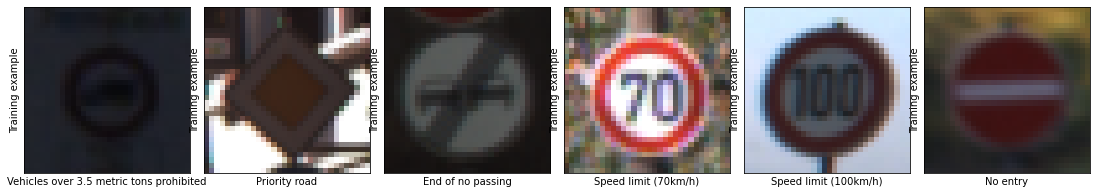

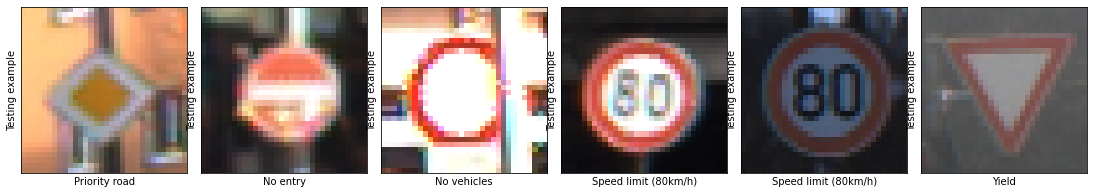

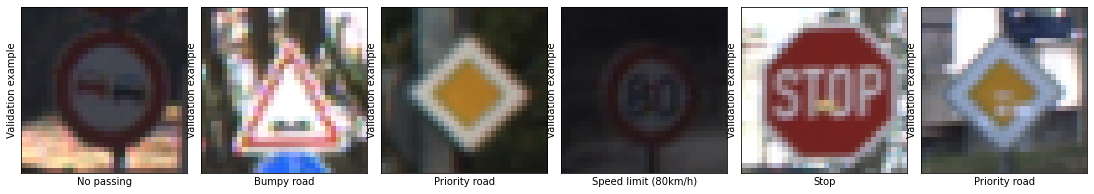

In [8]:
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

We can then use numpy to plot a histogram of the count of images in each unique class.

In [9]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

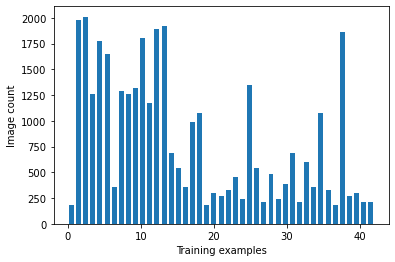

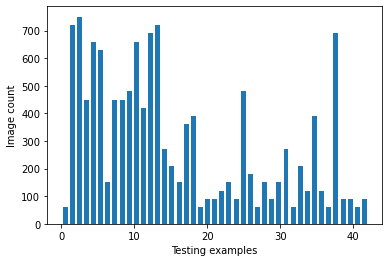

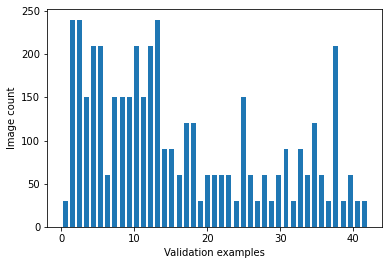

In [10]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

### Data Preprocessing
In this step, we will apply several preprocessing steps to the input images to achieve the best possible results.

We will use the following preprocessing techniques:

1. Shuffling.
2. Grayscaling.
3. Local Histogram Equalization.
4. Normalization.

**1. Shuffling:** In general, we shuffle the training data to increase randomness and variety in training dataset, in order for the model to be more stable. We will use sklearn to shuffle our data.

In [11]:
X_train, y_train = shuffle(X_train, y_train)

**2. Grayscaling:** In their paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" published in 2011, P. Sermanet and Y. LeCun stated that using grayscale images instead of color improves the ConvNet's accuracy. We will use OpenCV to convert the training images into grey scale.

In [12]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

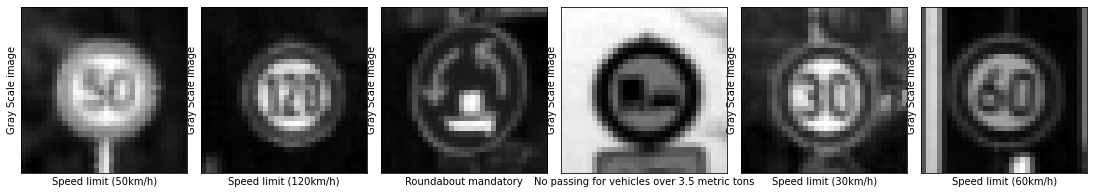

In [13]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

**3. Local Histogram Equalization:** This technique simply spreads out the most frequent intensity values in an image, resulting in enhancing images with low contrast. Applying this technique will be very helpfull in our case since the dataset in hand has real world images, and many of them has low contrast. We will use skimage to apply local histogram equalization to the training images.

In [14]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

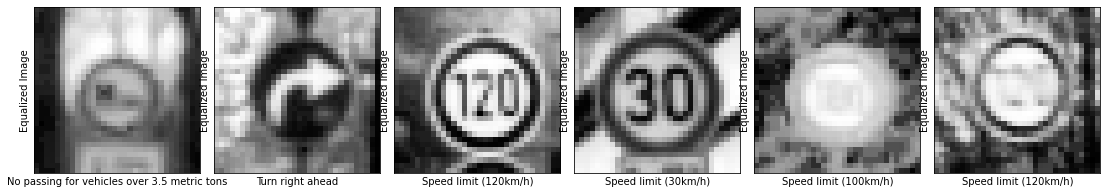

In [15]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

**4. Normalization:** Normalization is a process that changes the range of pixel intensity values. Usually the image data should be normalized so that the data has mean zero and equal variance.

In [16]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

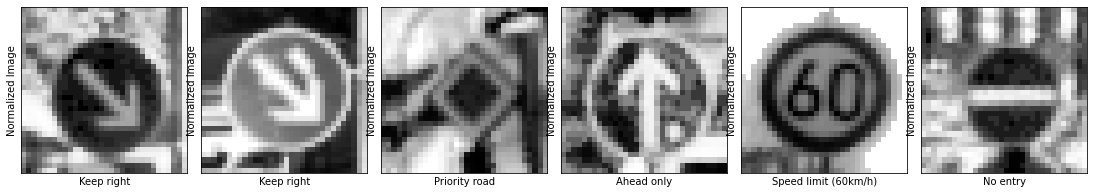

In [17]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [18]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [19]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In order to classify using the LeNet architecture, we need to transform the target into categorical values (i.e. 0 or 1) in order to depict the target value.

In [21]:
y_train = to_categorical(y_train,43)
y_test  = to_categorical(y_test,43)
y_valid = to_categorical(y_valid,43)

### Design a Model Architecture

In this step, we will design and implement a deep learning model that learns to recognize traffic signs from our dataset German Traffic Sign Dataset.

We'll use Convolutional Neural Networks to classify the images in this dataset. The reason behind choosing ConvNets is that they are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They automatically learn hierarchies of invariant features at every level from data. We will implement a common ConvNet: LeNet.

Our goal is to reach an accuracy of +90% on the validation set.

## Reshape data to 3D

In [22]:
train_x = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
val_x = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
test_x = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### Generate some datasets with different angles

In [23]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                                              height_shift_range=0.1,
                                              zoom_range=0.2,
                                              shear_range=0.1,
                                              rotation_range=10.)

datagen.fit(train_x)

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.layers import ReLU

def build_model():
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(60,(5,5), input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(ReLU())
    model.add(Conv2D(60,(5,5)))
    model.add(MaxPool2D(pool_size=(2, 2)))


    # Second Convolutional Layer
    model.add(Conv2D(30, (3,3)))
    model.add(ReLU())
    model.add(Conv2D(30, (3,3)))
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2)))


    # Flatten the model
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 re_lu (ReLU)                (None, 28, 28, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 re_lu_1 (ReLU)              (None, 10, 10, 30)        0         
                                                        

In [26]:
history = model.fit(datagen.flow(train_x, y_train, batch_size=64),
                                           steps_per_epoch=150,
                                            epochs=15,
                                            validation_data=(val_x, y_valid), shuffle=1)

Epoch 1/15
150/150 [==============================] - 19s 122ms/step - loss: 2.9952 - accuracy: 0.1967 - val_loss: 1.4392 - val_accuracy: 0.5481
Epoch 2/15
150/150 [==============================] - 22s 150ms/step - loss: 1.5358 - accuracy: 0.5452 - val_loss: 0.6861 - val_accuracy: 0.7968
Epoch 3/15
150/150 [==============================] - 18s 122ms/step - loss: 0.9816 - accuracy: 0.6995 - val_loss: 0.3347 - val_accuracy: 0.9005
Epoch 4/15
150/150 [==============================] - 19s 125ms/step - loss: 0.7271 - accuracy: 0.7790 - val_loss: 0.2876 - val_accuracy: 0.9075
Epoch 5/15
150/150 [==============================] - 19s 129ms/step - loss: 0.5670 - accuracy: 0.8266 - val_loss: 0.1772 - val_accuracy: 0.9469
Epoch 6/15
150/150 [==============================] - 18s 121ms/step - loss: 0.4624 - accuracy: 0.8570 - val_loss: 0.1560 - val_accuracy: 0.9494
Epoch 7/15
150/150 [==============================] - 18s 122ms/step - loss: 0.3918 - accuracy: 0.8803 - val_loss: 0.1169 - val_ac

### Visualizing accuracy

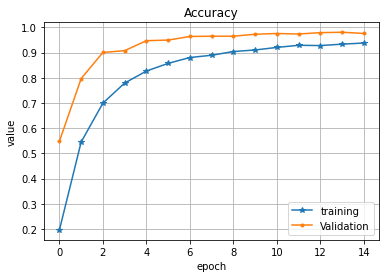

In [27]:
plt.plot(history.history['accuracy'],'*-')
plt.plot(history.history['val_accuracy'],'.-')
plt.legend(['training','Validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('value')
plt.grid(axis= 'both')

### Visualizing Loss

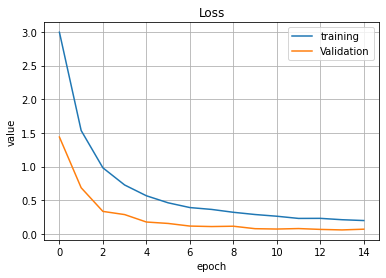

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','Validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.grid(axis= 'both')

### Model accuracy over test data

In [29]:
score = model.evaluate(test_x,y_test,verbose = 1)
print("The accuracy is ", score[1]*100)

395/395 [==============================] - 5s 14ms/step - loss: 0.1225 - accuracy: 0.9598
The accuracy is  95.97783088684082


### Testing the Model on New Images
In this step, we will use the model to predict traffic signs type of 5 random images of German traffic signs from the web our model's performance on these images.

In [30]:
# Loading and resizing new test images
new_test_images = []
path = '../data/new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
print("Number of new testing examples: ", len(new_test_images))

Number of new testing examples:  4


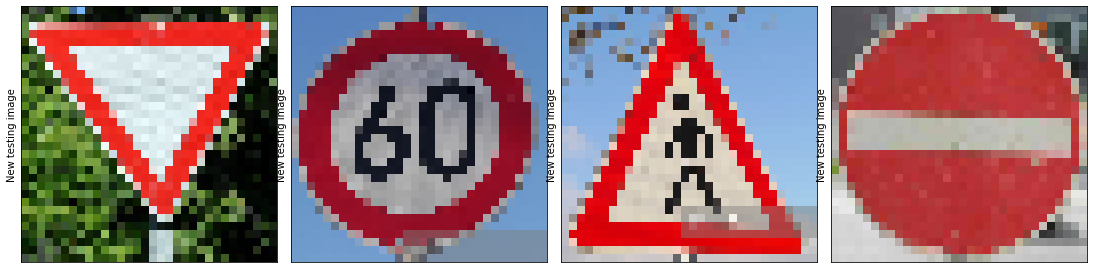

In [31]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(new_test_images[i])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [32]:
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

In [33]:
pp = model.predict(new_test_images_preprocessed)
p = np.argmax(pp,axis=1)
p

array([13,  3, 27, 17], dtype=int64)

In [34]:
pn = data.SignName.loc[p]
pn

13                   Yield
3     Speed limit (60km/h)
27             Pedestrians
17                No entry
Name: SignName, dtype: object

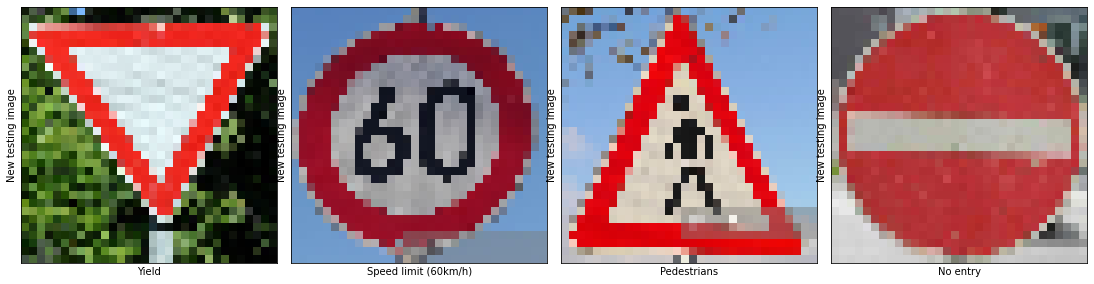

In [35]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(pn.iloc[i])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()